In [1]:
from google.colab import drive,auth

import gspread
import os
import pandas as pd

auth.authenticate_user()
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Magister - TFM')

os.listdir("./")

Mounted at /content/drive


['Lista de países.docx',
 '1. Escrito Tesis',
 '2. Datos',
 '3. Datos Tratados',
 '4. Informes de competitividad',
 '5. scritps',
 'Descripción del índice de competitividad y cambios en 2020.docx',
 'diccionario_indices.gsheet',
 'arial.ttf',
 'Notas TFM.gdoc',
 '6. Articulos Científicos']

In [2]:
# Lectura datos de índices

files = ["Trabajó de investigación 1.xlsx", "Trabajo de investigación 2.xlsx"]

bd_indx = []
colnames = []
for f in files:
  print(f"Lectura: {f}")
  bdaux = pd.read_excel("./2. Datos/"+f,sheet_name=None)
  periods = list(bdaux.keys())
  for y,df in bdaux.items():
    df['PERIODO'] = y
    bd_indx.append(df)
    colnames.append((len(df.columns.tolist()),y,df.columns.tolist()))


Lectura: Trabajó de investigación 1.xlsx
Lectura: Trabajo de investigación 2.xlsx


In [3]:
# Tranformacion de los Datos
# Por cada conjunto de valores (paises + valores de indicadores) hay un año y un conjunto de indicadores.

bd_indx_v2 = []
for bd in bd_indx:
  #print(list(set(bd['PERIODO'].tolist()))[0].split("-")[0])
  año = int(list(set(bd['PERIODO'].tolist()))[0].split("-")[0])
  bd = bd.dropna(subset=['Países'])
  bd = bd.rename(columns={'Países':'PAIS_COD'})
  bd_melt = bd.melt(
    id_vars=['PAIS_COD','PERIODO'],
    var_name='NUM_INDX',
    value_name='VALOR_INDICE'
  )
  bd_melt['AÑO'] = año
  bd_indx_v2.append(bd_melt)

bd_indx_v2 = pd.concat(bd_indx_v2)
bd_indx_v2['NUM_INDX'] = bd_indx_v2['NUM_INDX'].str.replace("P-","")
#bd_indx_v2 = bd_indx_v2.rename(columns={'Países':'PAIS_COD'})
display(bd_indx_v2)
#index_nums = []
#for bd in bd_indx:
#  año = int(list(set(bd['PERIODO'].tolist()))[0].split("-")[0])
#  bd.T


,PAIS_COD,PERIODO,NUM_INDX,VALOR_INDICE,AÑO
0,AUS,2014-2015,1.01,5.5,2014
1,AUT,2014-2015,1.01,5.8,2014
2,BEL,2014-2015,1.01,5.4,2014
3,BRA,2014-2015,1.01,4.0,2014
4,BGR,2014-2015,1.01,3.5,2014
...,...,...,...,...,...
1849,ZAF,2019,12.10,504.69,2019
1850,ZWE,2019,12.10,17.51,2019
1851,2020,2019,12.10,NaN,2019
1852,País,2019,12.10,NaN,2019


In [4]:
# Lectura información de paises
#import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

def read_pd_sheet(spreadsheet_name):
  spreadsheet = gc.open(spreadsheet_name)
  worksheet = spreadsheet.get_worksheet(0)
  data = worksheet.get_all_values()
  df = pd.DataFrame(data[1:], columns=data[0])
  return df

#Lectura desde google sheet
countries_info = read_pd_sheet("bd_paises_info")
display(countries_info.head())

# Crear 3 columnas: block y org
bd_indx_mrg = bd_indx_v2.merge(countries_info,left_on='PAIS_COD',right_on='PAIS_COD',how='left')
display(bd_indx_mrg.head())

,PAIS_COD,NOMBRE,ORG,BLOCK
0,ARE,U. Arab Emirates,BRICS,Asia
1,AUS,Australia,OECD,Oceanía
2,AUT,Austria,OECD,Europa Occ.
3,BEL,Belgium,OECD,Europa Occ.
4,BGR,Bulgaria,OECD,Europa Ori.


,PAIS_COD,PERIODO,NUM_INDX,VALOR_INDICE,AÑO,NOMBRE,ORG,BLOCK
0,AUS,2014-2015,1.01,5.5,2014,Australia,OECD,Oceanía
1,AUT,2014-2015,1.01,5.8,2014,Austria,OECD,Europa Occ.
2,BEL,2014-2015,1.01,5.4,2014,Belgium,OECD,Europa Occ.
3,BRA,2014-2015,1.01,4.0,2014,Brasil,BRICS,Latam
4,BGR,2014-2015,1.01,3.5,2014,Bulgaria,OECD,Europa Ori.


In [5]:
# Filtro por paises y año
lisofpaises = ['AUS', 'AUT', 'BEL', 'BRA', 'BGR', 'CAN', 'CHL', 'CHN', 'COL',
       'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'ISL',
       'IND', 'IRL', 'ISR', 'ITA', 'JPN', 'KOR', 'LVA', 'LTU', 'LUX',
       'MEX', 'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN',
       'ESP', 'SWE', 'CHE', 'TUR', 'GBR', 'USA', 'ARE', 'EGY', 'GHA',
       'IRN', 'JOR', 'KEN', 'LBN', 'MAR', 'NGA', 'QAT', 'SAU', 'SEN',
       'VNM', 'ZAF', 'ZWE']

# Filtros de lista de paises y de añis (2014 - 2019)
bd_indx_fil = bd_indx_mrg[(bd_indx_mrg['PAIS_COD'].isin(lisofpaises))&(bd_indx_mrg['AÑO']<=2019)]

bd_indx_fil.head()
# Eliminación de duplicados
display(f"ANTES:{len(bd_indx_fil)}")
bd_indx_fil = bd_indx_fil.drop_duplicates(subset=['PAIS_COD','AÑO','NUM_INDX'])
display(f"DESPUES:{len(bd_indx_fil)}")

'ANTES:36895'

'DESPUES:36792'

In [6]:
# Lectura de diccionario de índices
df_indicadores = pd.read_excel("./2. Datos/bd_diccionario_indices.xlsx")
df_indicadores['NUM_INDX'] = df_indicadores['NUM_INDX'].astype(str)
df_indicadores.keys()

# chequeo de dtypes y consistencia años
display(df_indicadores['AÑO'].dtype == bd_indx_fil['AÑO'].dtype)
display(df_indicadores['AÑO'].unique() == bd_indx_fil['AÑO'].unique())

True

array([ True,  True,  True,  True,  True,  True])

In [7]:
# Agregamos los pilares
usedcols = ['NUM_INDX', 'DESCRIPCION_INDX','DESCRIPCION_INDX_NORM', 'PILAR', 'SUBPILAR',
       'DESCRIPCION_PILAR', 'CATEGORIA_INDX', 'CATEGORIA_DESC',
       'FACTOR']
bd_final_indicadores = []
for año,df in bd_indx_fil.groupby('AÑO'):
  indicadores = df_indicadores[df_indicadores['AÑO']==año]
  df = df.merge(indicadores[usedcols],on='NUM_INDX',how='inner')
  #df = df.merge(indicadores,left_on='NUM_INDX',right_on='NUM_INDX',how='left')
  bd_final_indicadores.append(df)

bd_indx_final = pd.concat(bd_final_indicadores)
display(bd_indx_final.head())

# todos con descrpición
nodescrip = bd_indx_final[bd_indx_final['DESCRIPCION_INDX'].isna()]
nodescrip

#% de nan en valores de índice
bd_indx_final['VALOR_INDICE'].isna().sum()/len(bd_indx_final)*100
#indicadores['DESCRIPCION_INDX'].unique()

,PAIS_COD,PERIODO,NUM_INDX,VALOR_INDICE,AÑO,NOMBRE,ORG,BLOCK,DESCRIPCION_INDX,DESCRIPCION_INDX_NORM,PILAR,SUBPILAR,DESCRIPCION_PILAR,CATEGORIA_INDX,CATEGORIA_DESC,FACTOR
0,AUS,2014-2015,1.01,5.5,2014,Australia,OECD,Oceanía,Property rights,property rights,1,1,Instituciones,A,Requisitos Básicos,0.4
1,AUT,2014-2015,1.01,5.8,2014,Austria,OECD,Europa Occ.,Property rights,property rights,1,1,Instituciones,A,Requisitos Básicos,0.4
2,BEL,2014-2015,1.01,5.4,2014,Belgium,OECD,Europa Occ.,Property rights,property rights,1,1,Instituciones,A,Requisitos Básicos,0.4
3,BRA,2014-2015,1.01,4.0,2014,Brasil,BRICS,Latam,Property rights,property rights,1,1,Instituciones,A,Requisitos Básicos,0.4
4,BGR,2014-2015,1.01,3.5,2014,Bulgaria,OECD,Europa Ori.,Property rights,property rights,1,1,Instituciones,A,Requisitos Básicos,0.4


np.float64(0.2481743496120493)

In [8]:
# Guardado
bd_indx_final.to_excel("./3. Datos Tratados/bd_indices_wef.xlsx",index=False)


In [9]:
bd_indx_final[bd_indx_final["BLOCK"]=="Norteamerica"]['PAIS_COD'].unique()

array(['CAN', 'MEX', 'USA'], dtype=object)

,DESCRIPCION_INDX_NORM,AÑO
16,burden of government regulation,6
61,efficiency of legal framework in settling disp...,6
92,flexibility of wage determination,6
128,intellectual property protection,6
200,redundancy costs weeks of salary,6
205,reliance on professional management,6


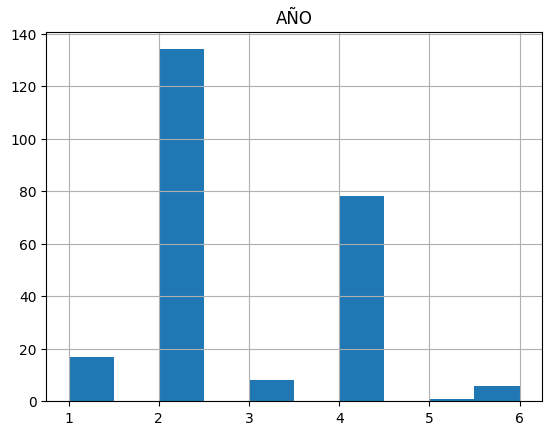

In [ ]:
# Indicadores presentes en todo el año: Ninguno
# Get the unique years in the DataFrame
unique_years = df_indicadores['AÑO'].unique()
num_unique_years = len(unique_years)
colindexname = "DESCRIPCION_INDX_NORM"

# Group by 'DESCRIPCION_INDX' and count the number of unique years for each description
description_year_counts = df_indicadores.groupby(colindexname)['AÑO'].nunique().reset_index()

# Filter to keep only descriptions that appear in all years
descriptions_in_all_years = description_year_counts[
    description_year_counts['AÑO'] == num_unique_years]


#descriptions_in_all_years
# Filter the original DataFrame
df_indicadores_filtered = df_indicadores[
    df_indicadores[colindexname].isin(descriptions_in_all_years)
]

description_year_counts
description_year_counts.hist()
#display(df_indicadores_filtered.head())

descriptions_in_all_years

In [ ]:
bd_indx_final.head()

,PAIS_COD,PERIODO,NUM_INDX,VALOR_INDICE,AÑO,NOMBRE,ORG,BLOCK,DESCRIPCION_INDX,DESCRIPCION_INDX_NORM,PILAR,SUBPILAR,DESCRIPCION_PILAR,CATEGORIA_INDX,CATEGORIA_DESC,FACTOR
0,AUS,2014-2015,1.01,5.5,2014,Australia,OECD,Oceanía,Property rights,property rights,1,1,Instituciones,A,Requisitos Básicos,0.4
1,AUT,2014-2015,1.01,5.8,2014,Austria,OECD,Europa Occ.,Property rights,property rights,1,1,Instituciones,A,Requisitos Básicos,0.4
2,BEL,2014-2015,1.01,5.4,2014,Belgium,OECD,Europa Occ.,Property rights,property rights,1,1,Instituciones,A,Requisitos Básicos,0.4
3,BRA,2014-2015,1.01,4.0,2014,Brasil,BRICS,Latam,Property rights,property rights,1,1,Instituciones,A,Requisitos Básicos,0.4
4,BGR,2014-2015,1.01,3.5,2014,Bulgaria,OECD,Europa Ori.,Property rights,property rights,1,1,Instituciones,A,Requisitos Básicos,0.4


In [ ]:
# Encoder de BLOCK y ORG
dic_org = {"OECD":1,"BRICS":2,"OTRO":3}
dic_block = {
    'Africa':1,'Asia':2,'Europa Occ.':3,
    'Europa Ori.':4,'Latam':5,'NorteAmerica':6,
    'Norteamerica':7,'Oceanía':8
    }

# Encodificado
bd_indx_final['ORG_COD'] = bd_indx_final['ORG'].map(dic_org)
bd_indx_final['BLOCK_COD'] = bd_indx_final['BLOCK'].map(dic_block)

bd_indx_final[['AÑO','PAIS_COD','ORG_COD','BLOCK_COD',"NUM_INDX",'VALOR_INDICE']].to_excel('./3. Datos Tratados/indices_wef_encoded.xlsx',index=False)
